# Going Deeper(NLP)

# 1. SentencePiece 사용하여 리뷰데이터 감정분석

* Writer :송영석
* Date : 2021.12.18

## 목차
    
    Step 1. SentencePiece    
        1. 데이터 로드
        2. SentencePiece 학습
        3. 모델 학습
        4. 모델 평가
    Step 2. 추가 분석 KoNLPy 형태소 분석기를 사용한 모델  
        1. 데이터 로드
        2. 데이터로더 구성
        3. 모델구성을 위한 데이터 분석 및 가공
        4. 모델 구성 및 validation set 구성
        5. 모델 훈련 개시
        6. Loss,Acurracy 그래프 시각화
        7. 학습된 Embedding 레이어 분석
        8. 한국어 Word2Vec 임베딩 활용하여 성능개선
    Step 3. 결과 정리

## Step 1. SentencePiece

* SentencePiece는 SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer이다.
* BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것이다.

* 앞서 배운 tokenize() 함수

In [ ]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

위와 같이 tf.keras.preprocessing.text.Tokenizer에 corpus를 주고 tokenizer.fit_on_texts(corpus)을 하면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해 주는 것입니다.   


그럼 이를 위해서 SentencePiece 모델을 학습하는 과정을 거쳐야 합니다.

 ### 1) 데이터 다운로드 및 분석

In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

#### 데이터 다운로드

In [2]:
train_data = []
test_data = []
import pandas as pd
import os
def get_data(x,data):
    path_to_file = os.getenv('HOME')+ x
    temp = pd.read_table(path_to_file)
    temp=temp.dropna(axis=0)
    data = temp['document'].values.tolist()       
    print("Data Size:", len(data))

    print("Example:")
    for sen in data[0:100][::20]: print(">>", sen)
    
    return data        
train_data=get_data('/aiffel/GoingDeeper_project/NLP_1/ratings_train.txt',train_data) 
test_data=get_data('/aiffel/GoingDeeper_project/NLP_1/ratings_test.txt',test_data)


Data Size: 149995
Example:
>> 아 더빙.. 진짜 짜증나네요 목소리
>> 나름 심오한 뜻도 있는 듯. 그냥 학생이 선생과 놀아나는 영화는 절대 아님
>> 단순하면서 은은한 매력의 영화
>> 보는내내 그대로 들어맞는 예측 카리스마 없는 악역
>> 뭐냐..시작하고 3분만에 나왔다. 리플릿 사진 보며 불안하더니만..
Data Size: 49997
Example:
>> 굳 ㅋ
>> '13일의 금요일', '나이트메어'시리즈와 함께 가장 많은 시리즈를 양산해냈던 헬레이저 시리즈의 첫편. 작가의 상상력이 돋보이는 작품이며, 갈고리로 사지찢는 고어씬은 지금보더라도 상당히 잔인하고 충격적이다.
>> EBS 한국영화특선 해서 봤다.Biff 개막작 선정되서 왤까 궁금 했었는데 봐도 이율 모르겠다...
>> 콩콩~~~~ㅋㄲㅈㅁ
>> 솔직히 이건 C급 그 이하의 영화이긴 함 ㅎㅎ;


In [3]:
y_train=[]
y_test=[]
def get_label (x,data):
    path_to_file = os.getenv('HOME')+ x
    temp = pd.read_table(path_to_file)
    temp=temp.dropna(axis=0)
    data = temp['label'].values.tolist()       
    print("Data Size:", len(data)) 
    
    return data  
y_train = get_label('/aiffel/GoingDeeper_project/NLP_1/ratings_train.txt',y_train)
y_test = get_label('/aiffel/GoingDeeper_project/NLP_1/ratings_test.txt',y_test)


Data Size: 149995
Data Size: 49997


In [4]:
print(len(train_data))
print(len(test_data))

149995
49997


In [5]:
print(len(y_train))
print(len(y_test))

149995
49997


#### 문장 길이 분석

Data Size: 149995
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


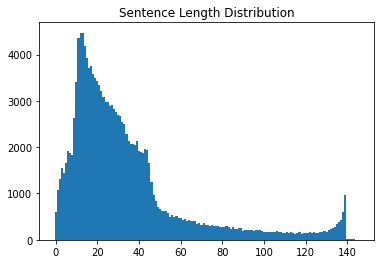

Data Size: 49997
문장의 최단 길이: 1
문장의 최장 길이: 144
문장의 평균 길이: 35


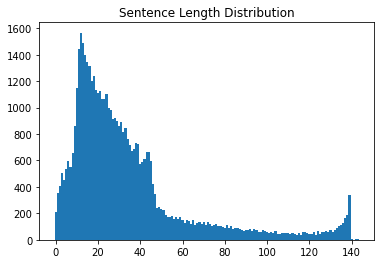

In [6]:
def sentence_length(raw):
    min_len = 999
    max_len = 0
    sum_len = 0
    Data_Size = len(raw)
    print("Data Size:", len(raw))

    for sen in raw:
        
        length = len(sen)
        if min_len > length: min_len = length
        if max_len < length: max_len = length
        sum_len += length

    print("문장의 최단 길이:", min_len)
    print("문장의 최장 길이:", max_len)
    print("문장의 평균 길이:", sum_len // Data_Size)

    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in raw:
        sentence_length[len(sen)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)  
    plt.title("Sentence Length Distribution")
    plt.show()
    
sentence_length(train_data)
sentence_length(test_data)

#### 데이터 전처리

1. 짧은 표현의 중복이 많아 제거
2. 너무 짧으면 노이즈가 될수 있으므로 10 이상 150이하 사용

In [7]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(train_data, 8)

카밀라벨 발연기
내용이 이상해;
너무 좋은 영화
가발 쓰고 싶다
0점은 없나??
말랑말랑 ...
그냥. 최고다.
감동적인 영화다
평점 조절...
재미없음 -_-
전율을 느꼈다.
재미잇음매우~~
좋네..괜찮고.
ㅋㅋㅋ 재미없음
파괴된 관객들.
나수윤의 발견!
너무 배배꼬았다
정말 재미있어요
그래서 2편은?
이건그냥 야동임
나에게는 수면제
같이울게햇으니까
레알 쩐다 ㅇㅇ
별반개도 아깝다
사랑해요 공효진
좋은 로맨스물.
개 쌈마이 영화
재밌다. 그뿐.
빛 좋은 개살구
쵝오의 드라마~
테러방지법...
진정 한심하다.
꼭보소 두번보소
여지없는 푸념.
아 양민수(2)
까브리머싯씀ㅎㅎ
별반개도 아깝다
개연성 개나줘.
그냥병맛ㅋㅋㅋㅋ
흠 좀 그렇던데
기대 이하다..
최고의 액션배우
명작...ㅎㅎ;
추억의 명작만화
진리와 평등이제
공포영화 맞니?
개구쟁이 스머프
닥치고 내돈내놔
감독의 내공부족
이거 꾀 재밌다
양요섭 표절논란
별로 같은뎅..
멋지다 조문탁!
인내력 테스트.
이건 뭘 까요?
저평가된 007
어덜트 비디오용
박찬욱편의 승리
화끈한 액션영화
디카프리오, 끝
심형래니까 1점
쫌 아니다...
시간잘때웠습니당
희극 또는 비극
진부한 재난영화
So What?
멸망 ㅈㄹ 한다
하나의 예술작품
완전 재밋습니다
zzzzzzzz
아프네요 가슴이
오자룡은기어갔냐
김리나가 이쁘다
동영상 안 나와
아름다우네요,,
안보여요 ///
이거 너무 좋아
그닥 재미없던데
이것도 영화냐?
한국영화 참아라
흑 부럽다.ㅋㅋ
너무 뻔한 전개
얘네들 뭐냐;;
형식미의 절정.
인상적인 영화.
전설까지야...
휴그랜트만의영화
2도 볼만함..
헛웃음만 나와.
보지마요....
사토시가나오니까
제목 그대로 ~
재밌을것 같아요
스토리가 좋네요
평점 왜케 낮어
영화이해가 안됨
ㅡ.,ㅡ; 뭐얌
재밌겠당..~~
난졸라재밋게봣음
0점은 없는건지
으헝 재미없겠디


In [8]:
check_sentence_with_length(test_data, 8)

너무너무 재밌다
완전 잼없음..
뭘 만든 건가?
뭐야이거 무서워
역시 팀 버튼.
현실은 이러하다
좋아요..^.^
오리지날이다..
숨겨진 명화!!
획기적인 영화.
짐캐리만의 영화
다보고 느낀점수
아.......
1점도 아깝다.
봐도봐도 잼있음
난 재밌게 봣네
아, 좋은 영화
재밌게봤어요^^
재밌게 봤어요.
꼭봐야할영화~~
평점을 올리자~
ㅋㅋ 짱재밌어요
아름답고 슬프다
표적 없는 총질
ㅋㅋㅋㅋㅋ재밌당
동화같은 드라마
키스마스가 쵝오
지루해서 잠을잠
재미읎다....
완전 삼류;;;
최고의 드라마.
임때문에 별하나
크로넨버그 최고
그냥......
저도 존경합니다
포스터봐라 ㅋㅋ
최고의순수의영화
wow~재밋어요
1점이 아깝다.
엄청재이있겠네요
잘나갔지 콜트~
과분한 점수닷.
..--;엽기다
뭐하자는거야지금
이 무슨....
박진희 최고 ㅋ
지루한 게이물.
더럽게 재미없네
내 인생의 영화
그저 그렇다..
역시 서울대였군
마음에 듭니다.
개 싸이코 영화
감상문때문에 봄
명작 드래곤볼!
진짜.ㅋㅋㅋㅋㅋ
환상적인 재미.
빼꼼의머그잔여행
지루하네요...
느낌 좋은 영화
재미없어 - -
열나게 재미없네
따뜻한 영화^^
뭐고 이거...
최악의 영화였다
재밌었어요ㅋㅋㅋ
괜찮았는데...
아니다 이건..
뭔 내용인지??
떡밥계의 최고봉
소재가 고갈된듯
재밌게봤음ㅋㅋㅋ
필림이 아깝다.
포스터가 드럽다
심하게 재미없네
전혜진만 이쁘긔
졸라게 재미없어
전설의 시작..
너무 좋앙...
잼있게본 영화!
선리플 후 감상
1보다는 약하다
평점 버그 ㄱㄱ
숀펜진짜..ㄷㄷ
아름다운영화..
너무 재미있어요
잔잔하다 예쁘다
평이 너무 낮음
재미있어요 ㅎㅎ
이건진짜명작이죠
좋은영화....
너무 유치하다.
깨끗한울음 눈물
재밌었어요~^^
구렛나루의 압박
딱봐도 젬없겠네
당황스럽다...
완전대박잼있어요
시간 떼우기 용
이게 뭐지..?
평점이 너무낮다


In [9]:
df_train = pd.DataFrame({'x':train_data,'label':y_train})
df_test = pd.DataFrame({'x':test_data,'label':y_test})

print(len(df_train))
print(len(df_test))

149995
49997


In [10]:
df_train.drop_duplicates(["x"], inplace=True)
df_test.drop_duplicates(["x"], inplace=True)

print(len(df_train))
print(len(df_test))

146182
49157


Data Size: 136253


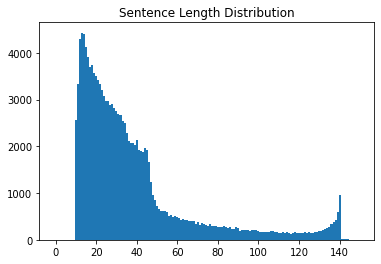

Data Size: 45645


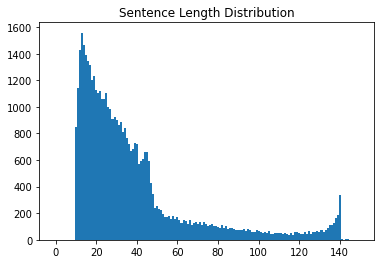

In [11]:
def modify_length(cleaned_corpus):
    max_len = 150
    min_len = 10
    # 길이 조건에 맞는 문장만 선택합니다.
  
    cleaned_corpus["len"] = cleaned_corpus["x"].apply(lambda x: len(x))    
    filtered_corpus = cleaned_corpus.loc[(cleaned_corpus["len"] >= min_len) & (cleaned_corpus["len"] <= max_len)]
    
    
    # 분포도를 다시 그려봅니다.
    sentence_length = np.zeros((max_len), dtype=np.int)

    for sen in filtered_corpus['len']:
        sentence_length[sen] += 1
    
    print("Data Size:", len(filtered_corpus))
    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("Sentence Length Distribution")
    plt.show()
    return filtered_corpus

filtered_train = modify_length(df_train)
filtered_test = modify_length(df_test)

In [12]:
y_train = filtered_train['label'].values.tolist() 
y_test = filtered_test['label'].values.tolist() 


filtered_train = filtered_train['x'].values.tolist() 
filtered_test = filtered_test['x'].values.tolist() 


### 2) SentencePiece 학습

In [13]:
import sentencepiece as spm

import os
temp_file = os.getenv('HOME')+'/aiffel/GoingDeeper_project/NLP_1/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_train:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 374762 Dec 18 13:18 korean_spm.model
-rw-r--r-- 1 root root 144036 Dec 18 13:18 korean_spm.vocab


In [14]:
import tensorflow as tf  
from tensorflow import keras 

def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [15]:

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

X_train_sp, X_train_word_index, X_train_index_word = sp_tokenize(s, filtered_train)
X_test_sp, X_test_word_index, X_test_index_word = sp_tokenize(s, filtered_test)

X_train_sp.shape

(136253, 134)

In [16]:
# validation set 10000건 분리
x_val_sp = X_train_sp[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train_sp = X_train_sp[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train_sp.shape)
print(np.array(partial_y_train).shape)

(126253, 134)
(126253,)


* label 데이터의 type을 model에 넣을 수 있게 array로 바꿔줍니다.

In [17]:
y_val = np.array(y_val)
partial_y_train = np.array(partial_y_train)
y_test=np.array(y_test)

### 3) 모델 학습 

3가지 모델 사용하여 분석했습니다.  
    * LSTM  
    * MAXpooling  
    * 1-D CNN  

#### 1) LSTM 설계 & 학습

In [18]:
vocab_size = 8000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

s_model_lstm = keras.Sequential()
s_model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
s_model_lstm.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
s_model_lstm.add(keras.layers.Dense(8, activation='relu'))
s_model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

s_model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          128000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 128,881
Trainable params: 128,881
Non-trainable params: 0
_________________________________________________________________


In [19]:
s_model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
history_lstm = s_model_lstm.fit(partial_x_train_sp,
                   partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val_sp, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 9s 25ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 2/20
247/247 [==============================] - 5s 22ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4998
Epoch 3/20
247/247 [==============================] - 5s 22ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 4/20
247/247 [==============================] - 5s 22ms/step - loss: 0.6931 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 5/20
247/247 [==============================] - 5s 22ms/step - loss: 0.6931 - accuracy: 0.5019 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 6/20
247/247 [==============================] - 5s 22ms/step - loss: 0.6931 - accuracy: 0.5018 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 7/20
247/247 [==============================] - 5s 22ms/step - loss: 0.6931 - accuracy: 0.5004 - val_loss: 0.6932 - val_accuracy: 0.5002

#### 2) MaxPooling 설계 & 학습

In [20]:
vocab_size = 8000 # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

s_model_max = keras.Sequential()
s_model_max.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
s_model_max.add(keras.layers.GlobalMaxPooling1D())
s_model_max.add(keras.layers.Dense(8, activation='relu'))
s_model_max.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

s_model_max.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 128,145
Trainable params: 128,145
Non-trainable params: 0
_________________________________________________________________


In [21]:
s_model_max.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
history_max = s_model_max.fit(partial_x_train_sp,
                   partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val_sp, y_val),
                    verbose=1)

Epoch 1/20
247/247 [==============================] - 3s 8ms/step - loss: 0.6687 - accuracy: 0.6258 - val_loss: 0.4876 - val_accuracy: 0.8154
Epoch 2/20
247/247 [==============================] - 2s 8ms/step - loss: 0.4337 - accuracy: 0.8334 - val_loss: 0.3542 - val_accuracy: 0.8480
Epoch 3/20
247/247 [==============================] - 2s 7ms/step - loss: 0.3252 - accuracy: 0.8643 - val_loss: 0.3360 - val_accuracy: 0.8547
Epoch 4/20
247/247 [==============================] - 2s 7ms/step - loss: 0.2929 - accuracy: 0.8771 - val_loss: 0.3368 - val_accuracy: 0.8568
Epoch 5/20
247/247 [==============================] - 2s 8ms/step - loss: 0.2710 - accuracy: 0.8871 - val_loss: 0.3404 - val_accuracy: 0.8556
Epoch 6/20
247/247 [==============================] - 2s 7ms/step - loss: 0.2537 - accuracy: 0.8969 - val_loss: 0.3463 - val_accuracy: 0.8545
Epoch 7/20
247/247 [==============================] - 2s 8ms/step - loss: 0.2416 - accuracy: 0.9016 - val_loss: 0.3544 - val_accuracy: 0.8520
Epoch 

#### 3) 1-D CNN 살계 및 학습

In [22]:
vocab_size = 8000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)


s_model_cnn = keras.Sequential()
s_model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
s_model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
s_model_cnn.add(keras.layers.MaxPooling1D(5))
s_model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
s_model_cnn.add(keras.layers.GlobalMaxPooling1D())
s_model_cnn.add(keras.layers.Dense(8, activation='relu'))
s_model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

s_model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          128000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [23]:
s_model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 
history_cnn = s_model_cnn.fit(partial_x_train_sp,
                   partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val_sp, y_val),
                    verbose=1)

Epoch 1/5
247/247 [==============================] - 14s 40ms/step - loss: 0.6260 - accuracy: 0.6436 - val_loss: 0.3395 - val_accuracy: 0.8518
Epoch 2/5
247/247 [==============================] - 3s 13ms/step - loss: 0.3182 - accuracy: 0.8661 - val_loss: 0.3211 - val_accuracy: 0.8604
Epoch 3/5
247/247 [==============================] - 3s 12ms/step - loss: 0.2888 - accuracy: 0.8795 - val_loss: 0.3203 - val_accuracy: 0.8612
Epoch 4/5
247/247 [==============================] - 3s 13ms/step - loss: 0.2631 - accuracy: 0.8926 - val_loss: 0.3237 - val_accuracy: 0.8597
Epoch 5/5
247/247 [==============================] - 3s 13ms/step - loss: 0.2440 - accuracy: 0.9017 - val_loss: 0.3275 - val_accuracy: 0.8632


### 4) 모델 평가

In [24]:
s_model_lstm.evaluate(X_test_sp, y_test)

1427/1427 [==============================] - 10s 7ms/step - loss: 0.6932 - accuracy: 0.4974


[0.6931812167167664, 0.49738195538520813]

In [25]:
s_model_max.evaluate(X_test_sp, y_test)

1427/1427 [==============================] - 4s 2ms/step - loss: 0.5291 - accuracy: 0.8282


[0.5291448831558228, 0.828152060508728]

In [26]:
s_model_cnn.evaluate(X_test_sp, y_test)

1427/1427 [==============================] - 8s 4ms/step - loss: 0.3468 - accuracy: 0.8525


[0.3468334376811981, 0.8524920344352722]

 ||LSTM|MaxPooling|1-D CNN
 |------|-----|:-----:|----
 |정확도|0.497|0.826|**0.851**


#### 역경을 겪은 점
1. LSTM 모델이 정확도가 너무 낮게 나와 parameter 수정을 하였지만 별 차이가 없어서 데이터부터 다시 확인하였었습니다. 결국엔 다른 모델을 도입하고서야 정확도가 정상적으로 (80% 이상) 나오게 되었는데 LSTM모델 연구를 더 해봐야 될 것 같습니다.
2. label 있다는 점을 고려하지 않고 처음부터 분리하여 데이터 전처리 과정에서 다시 합쳐줬어야 했고,y 값을 array type으로 바꿔줘야 한다는 점을 고려 못했다는 점 역시 시간을 허비하게 하였었다.

## step 2 .추가 분석 KoNLPy 형태소 분석기를 사용한 모델

### 1) 데이터 로드

In [27]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/GoingDeeper_project/NLP_1/ratings_train.txt')
test_data = pd.read_table('~/aiffel/GoingDeeper_project/NLP_1/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 2) 데이터로더 구성

data_loader 안의 기능들

* 데이터의 중복 제거
* NaN 결측치 제거
* 한국어 토크나이저로 토큰화
* 불용어(Stopwords) 제거
* 사전word_to_index 구성
* 텍스트 스트링을 사전 인덱스 스트링으로 변환
* X_train, y_train, X_test, y_test, word_to_index 리턴


In [28]:

from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words) 
    #counter 메서드를 이용하여 카운팅
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index


In [29]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 
print(f'train data 개수: {len(X_train)}, test data 개수: {len(X_test)}')

train data 개수: 146182, test data 개수: 49157


{숫자:단어} 의 딕셔너리 index_to_word 생성한다.

In [30]:
index_to_word = {index:word for word, index in word_to_index.items()}

다음의 기능을 수행하는 함수들을 정의한다.


* get_encoded_sentence : 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
* get_encoded_sentences : 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수
* get_decoded_sentence : 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
* get_decoded_sentences : 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수

In [31]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [32]:
# 1번째 리뷰데이터
print(X_train[0])
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


### 3) 모델구성을 위한 데이터 분석 및 가공

In [33]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


* keras.preprocessing.sequence.pad_sequences 을 활용하여 패딩을 추가한다.

In [34]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


### 4) 모델구성 및 validation set 구성

1) LSTM

In [35]:
vocab_size = 10000  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_lstm = keras.Sequential()
model_lstm.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_lstm.add(keras.layers.Dense(8, activation='relu'))
model_lstm.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


2) 1-D Convolution Neural Network(1-D CNN)

* 텍스트를 처리하기 위해 RNN이 아니라 1-D Convolution Neural Network(1-D CNN)를 사용할 수도 있습니다.
*  CNN 계열은 RNN 계열보다 병렬처리가 효율적이기 때문에 학습 속도도 훨씬 빠르게 진행된다는 장점

In [36]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 단어 하나를 표현하는 임베딩 벡터의 차원수 (변경가능)


model_cnn = keras.Sequential()
model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(8, activation='relu'))
model_cnn.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

3)  GlobalMaxPooling1D()

In [37]:
vocab_size = 10000 # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 16   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model_max = keras.Sequential()
model_max.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_max.add(keras.layers.GlobalMaxPooling1D())
model_max.add(keras.layers.Dense(8, activation='relu'))
model_max.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_max.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시

In [38]:
# validation set 10000건 분리
x_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)


(136182, 41)
(136182,)


In [39]:
print(type(x_val))

<class 'numpy.ndarray'>


1) LSTM 훈련

In [40]:
model_lstm.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs = 20

history_lstm = model_lstm.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/20
266/266 [==============================] - 5s 12ms/step - loss: 0.6640 - accuracy: 0.5613 - val_loss: 0.3963 - val_accuracy: 0.8281
Epoch 2/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3633 - accuracy: 0.8462 - val_loss: 0.3434 - val_accuracy: 0.8477
Epoch 3/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3187 - accuracy: 0.8650 - val_loss: 0.3389 - val_accuracy: 0.8508
Epoch 4/20
266/266 [==============================] - 3s 10ms/step - loss: 0.3053 - accuracy: 0.8705 - val_loss: 0.3447 - val_accuracy: 0.8519
Epoch 5/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2880 - accuracy: 0.8779 - val_loss: 0.3508 - val_accuracy: 0.8495
Epoch 6/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2769 - accuracy: 0.8803 - val_loss: 0.3585 - val_accuracy: 0.8478
Epoch 7/20
266/266 [==============================] - 3s 10ms/step - loss: 0.2661 - accuracy: 0.8831 - val_loss: 0.3645 - val_accuracy: 0.8459

In [41]:
results_lstm = model_lstm.evaluate(X_test,  y_test, verbose=2)
print(results_lstm)

1537/1537 - 5s - loss: 0.4614 - accuracy: 0.8406
[0.4613687992095947, 0.8405516743659973]


2) 1-D Convolution Neural Network(1-D CNN) 훈련

In [42]:
model_cnn.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=20

history_cnn = model_cnn.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/20
266/266 [==============================] - 14s 33ms/step - loss: 0.6302 - accuracy: 0.6413 - val_loss: 0.4734 - val_accuracy: 0.8389
Epoch 2/20
266/266 [==============================] - 2s 8ms/step - loss: 0.4476 - accuracy: 0.8549 - val_loss: 0.4326 - val_accuracy: 0.8493
Epoch 3/20
266/266 [==============================] - 2s 8ms/step - loss: 0.3916 - accuracy: 0.8744 - val_loss: 0.4156 - val_accuracy: 0.8494
Epoch 4/20
266/266 [==============================] - 2s 8ms/step - loss: 0.3523 - accuracy: 0.8870 - val_loss: 0.4022 - val_accuracy: 0.8505
Epoch 5/20
266/266 [==============================] - 2s 8ms/step - loss: 0.3119 - accuracy: 0.9033 - val_loss: 0.3992 - val_accuracy: 0.8481
Epoch 6/20
266/266 [==============================] - 2s 8ms/step - loss: 0.2775 - accuracy: 0.9163 - val_loss: 0.4060 - val_accuracy: 0.8453
Epoch 7/20
266/266 [==============================] - 2s 8ms/step - loss: 0.2492 - accuracy: 0.9274 - val_loss: 0.4220 - val_accuracy: 0.8437
Epoc

In [43]:
results_cnn = model_cnn.evaluate(X_test,  y_test, verbose=2)
print(results_cnn)

1537/1537 - 6s - loss: 0.7284 - accuracy: 0.8304
[0.7283788919448853, 0.8303598761558533]


3) GlobalMaxPooling1D() 훈련

In [44]:
model_max.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

epochs=20

history_max = model_max.fit(partial_x_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/20
266/266 [==============================] - 2s 6ms/step - loss: 0.6455 - accuracy: 0.7006 - val_loss: 0.4003 - val_accuracy: 0.8301
Epoch 2/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3760 - accuracy: 0.8395 - val_loss: 0.3522 - val_accuracy: 0.8433
Epoch 3/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3222 - accuracy: 0.8644 - val_loss: 0.3447 - val_accuracy: 0.8486
Epoch 4/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2939 - accuracy: 0.8783 - val_loss: 0.3459 - val_accuracy: 0.8496
Epoch 5/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2698 - accuracy: 0.8902 - val_loss: 0.3502 - val_accuracy: 0.8474
Epoch 6/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2576 - accuracy: 0.8964 - val_loss: 0.3577 - val_accuracy: 0.8484
Epoch 7/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2443 - accuracy: 0.9015 - val_loss: 0.3658 - val_accuracy: 0.8479
Epoch 

In [45]:
results_max = model_max.evaluate(X_test,  y_test, verbose=2)
print(results_max)

1537/1537 - 2s - loss: 0.5207 - accuracy: 0.8264
[0.5207210183143616, 0.8263522982597351]


### 6) Loss, Accuracy 그래프 시각화

1) LSTM 시각화

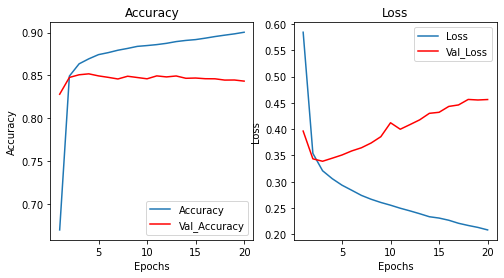

In [46]:
history_dict_lstm = history_lstm.history
acc = history_dict_lstm['accuracy']
val_acc = history_dict_lstm['val_accuracy']
loss = history_dict_lstm['loss']
val_loss = history_dict_lstm['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

2) 1-D Conv 시각화

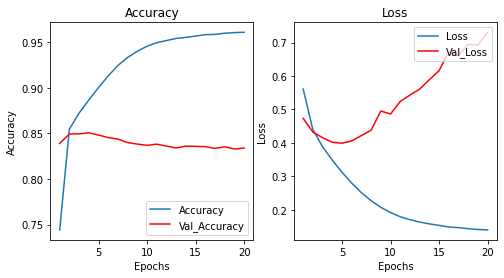

In [47]:
history_dict_cnn  = history_cnn.history
acc = history_dict_cnn ['accuracy']
val_acc = history_dict_cnn['val_accuracy']
loss = history_dict_cnn['loss']
val_loss = history_dict_cnn['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

3) GlobalMaxPooling 시각화

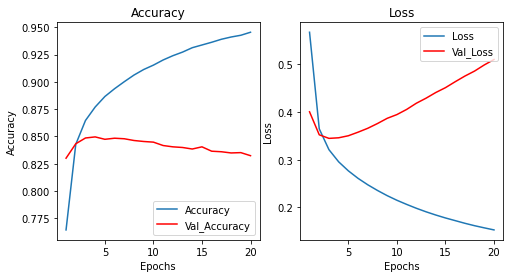

In [48]:
history_dict_max = history_max.history
acc = history_dict_max['accuracy']
val_acc = history_dict_max['val_accuracy']
loss = history_dict_max['loss']
val_loss = history_dict_max['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Accuracy')
plt.plot(epochs, val_acc, 'red', label='Val_Accuracy')
plt.legend(loc='lower right')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Loss')
plt.plot(epochs, val_loss, 'red', label='Val_Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

#### 훈련 결과
epoch을 20으로 주고 확인결과 
* LSTM : 0.8406
* 1-D CNN : 0.8304 
* MaxPooling : 0.8264

따라서 accuracy에 의한 성능은 **LSTM이 가장 좋았다.**



### 7)  학습된 Embedding 레이어 분석

In [49]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [50]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/LMS/sentiment_classification/data/word2vec_project.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(특수문자 4개는 제외)만큼의 워드 벡터를 파일에 기록
vectors = model_lstm.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [51]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

word_vectors.similar_by_word("사랑")

[('멋지', 0.9568766355514526),
 ('베를린', 0.9399263858795166),
 ('본방', 0.937951922416687),
 ('맬', 0.9373687505722046),
 ('은근', 0.9365289211273193),
 ('H', 0.9320493936538696),
 ('애절', 0.9319084882736206),
 ('따뜻', 0.9308945536613464),
 ('뛰어났', 0.9291821122169495),
 ('유쾌', 0.929126501083374)]

In [52]:
word_vectors.similar_by_word("액션")

[('저리', 0.8268165588378906),
 ('묘사', 0.7915400266647339),
 ('전해', 0.7848656177520752),
 ('인칭', 0.7789567112922668),
 ('아름다움', 0.7789373397827148),
 ('선언', 0.770919919013977),
 ('특수', 0.7617721557617188),
 ('넘어선', 0.7590972781181335),
 ('로멘', 0.7585985064506531),
 ('건물', 0.7527547478675842)]

### 8) 한국어 Word2Vec 임베딩 활용하여 성능개선

In [53]:
pip install gensim==3.8.1

     |████████████████████████████████| 24.2 MB 24.9 MB/s eta 0:00:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.0.1
    Uninstalling gensim-4.0.1:
      Successfully uninstalled gensim-4.0.1
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [53]:
import gensim
gensim.__version__

'3.8.1'

In [54]:
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/LMS/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector.shape


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


(200,)

In [55]:
word2vec.similar_by_word("지루")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  """Entry point for launching an IPython kernel.


[('답답', 0.7367106676101685),
 ('편안', 0.7046725749969482),
 ('솔직', 0.689364492893219),
 ('쓸쓸', 0.6880695819854736),
 ('차분', 0.6868932247161865),
 ('조용', 0.6765609383583069),
 ('냉정', 0.6706622838973999),
 ('자유분방', 0.6680829524993896),
 ('피곤', 0.6597293019294739),
 ('느긋', 0.659047544002533)]

In [56]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [57]:
from tensorflow.keras.initializers import Constant
model_ko = keras.Sequential()

model_ko.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True)) 
model_ko.add(keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_ko.add(keras.layers.Dense(8, activation='relu'))
model_ko.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_ko.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [61]:
# 학습의 진행
model_ko.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_ko = model_ko.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
266/266 [==============================] - 15s 50ms/step - loss: 0.0488 - accuracy: 0.9831 - val_loss: 0.7120 - val_accuracy: 0.8485
Epoch 2/20
266/266 [==============================] - 13s 48ms/step - loss: 0.0427 - accuracy: 0.9852 - val_loss: 0.7508 - val_accuracy: 0.8477
Epoch 3/20
266/266 [==============================] - 13s 48ms/step - loss: 0.0382 - accuracy: 0.9868 - val_loss: 0.7670 - val_accuracy: 0.8507
Epoch 4/20
266/266 [==============================] - 13s 48ms/step - loss: 0.0353 - accuracy: 0.9872 - val_loss: 0.7487 - val_accuracy: 0.8479
Epoch 5/20
266/266 [==============================] - 13s 48ms/step - loss: 0.0344 - accuracy: 0.9876 - val_loss: 0.7737 - val_accuracy: 0.8485
Epoch 6/20
266/266 [==============================] - 13s 48ms/step - loss: 0.0308 - accuracy: 0.9888 - val_loss: 0.7570 - val_accuracy: 0.8497
Epoch 7/20
266/266 [==============================] - 13s 48ms/step - loss: 0.0306 - accuracy: 0.9889 - val_loss: 0.7989 - val_accuracy:

결과적으로...  
Word2Vec를 사용하였을 때 기존의 임베딩에서 LSTM으로 동일한 학습을 진행했던 것 보다 정확도가 상승하였다.  
LSTM의 Accuracy : 0.8406(기존의 임베딩) -> 0.8514(Word2Vec 사용 시)

In [62]:
# 테스트셋을 통한 모델 평가
results_ko = model_ko.evaluate(X_test,  y_test, verbose=2)

print(results_ko)

1537/1537 - 6s - loss: 0.9812 - accuracy: 0.8493
[0.9812068343162537, 0.8492991924285889]


# Step 3. 결과정리 

###  <Step 1. SentencePiece를 이용한 감정분석>의 과정 
1. 네이버 영화리뷰 데이터를 다운 받아 전처리 과정을 거쳤습니다. 학습에 노이즈가 생기지 않게 중복 값을 제거 해주고  
   작은 문장들 역시 학습에 방해되어 10~150 길이의 문장만 선택하였습니다.
2. SentencePiece를 적용시킨 모델로 sp_tokenize() 메소드를 구현하여 모델을 학습
3. 데이터를 validation과 train으로 분리해줍니다.
4. LSTM,MaxPooling,1-D CNN 세가지 모델을 사용하여 학습한 후 가장 정확도가 좋은 모델을 결정
5. 모델 테스트 결과 **1-D CNN이 약 0.85**로 가장 높은 정확도를 보였습니다.


### <Step 2. 추가 분석 KoNLPy 형태소 분석기를 사용한 모델>의 과정

1. 위와 같은 데이터를 가져오고 데이터 로더 함수를 이용해 전처리를 해줍니다.
2. tokenize 되어진 데이터의 길이 등을 분석한 뒤 train, test 데이터를 생성합니다.
3. LSTM, MaxPooling, 1-D CNN 세가지 모델을 구성하여 모델을 훈련 합니다.
4. Loss와 Accuracy 등을 시각화하여 보여주고 훈련 결과를 출력하였습니다.
5. 학습된 Embedding 레이어를 성능을 확인하고 Word2Vec를 이용해 임베딩의 성능을 개선해줍니다.

### 결과 정리
   * SentencePiece에서는 1-D CNN의 정확도가 가장 높았고, KoNLPy를 사용했을 때는 LSTM이 가장 정확도가 좋아서 이 모델에 Word2Vec을 적용하여 정확도를 구했다.
   * 전체 결과는 아래와 같았고 Word2Vec과 같이 embedding을 건들지 않으면 **SentecePiece에 1-D CNN이 가장 성능이 좋았다**고 할 수 있겠다.

||LSTM|MaxPooling|1-D CNN
|------|-----|-----|----
|SentencePiece|0.497|0.826|**0.851**
|KoNLPy|**0.8406**|0.8264|0.8304
|KoNLPy + Word2vec|**0.8493**|X|X

#### Step 1...역경을 겪은 점
1. LSTM 모델이 정확도가 너무 낮게 나와 parameter 수정을 하였지만 별 차이가 없어서 데이터부터 다시 확인하였었습니다. 결국엔 다른 모델을 도입하고서야 정확도가 정상적으로 (80% 이상) 나오게 되었는데 LSTM모델 연구를 더 해봐야 될 것 같습니다.
2. label 있다는 점을 고려하지 않고 처음부터 분리하여 데이터 전처리 과정에서 다시 합쳐줬어야 했고,y 값을 array type으로 바꿔줘야 한다는 점을 고려 못했다는 점 역시 시간을 허비하게 하였었다.

#### Step 2...역경을 겪은 점

1) 추가 분석에서는 지난 번에 해보지 못한 3가지 모델을 다 적용해 보며 최선의 모델을 찾아내려고 하였고 parameter 또한 몇몇 수정해보았습니다.  
2) Word2Vec의 사용이 조금 헷갈리고 오류가 났었는데 gensim의 버전을 오히려 3.8로 낮춰주면서 라이브러리 사용에 오류를 제거 하였었다.